In [2]:
import importlib
import itertools
import json
import pickle
from pathlib import Path

import Bio
import logomaker
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyBigWig
import scipy.stats
import seaborn as sns
import utils
from Bio import SeqIO, SeqUtils
from matplotlib.colors import to_rgba
from scipy.stats import pearsonr, spearmanr
from statsmodels import api as sm

In [3]:
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

yeastdir = Path("/home/alex/shared_folder/SCerevisiae")
resdir = Path("/home/alex/SCerevisiae_chromatin_NN_prediction/Trainedmodels")
model_nuc_name = "model_myco_nuc_pt8"  # "model_myco_nuc_2"
# model_coh_name = "model_myco_coh_14"
model_pol_name = "model_myco_pol_pt8"  # "model_myco_pol_17"
model_nucpol_name = "model_myco_nucpol_pt8"
genome_names = [
    "W303_Mmmyco",
    "S288c_Mpneumo",
    "Pfalciparum3D7",
    "18kb-YAC_synthetic",
    "B8B_pBelo_Seq",
    "CALCOCO1-YAC_mm7_RP24-128N15",
    "FDp92",
]

In [4]:
def get_avg_annot_bychr(file):
    res = {}
    with pyBigWig.open(str(file)) as bw:
        for chr_id in bw.chroms():
            if chr_id.endswith("_rev"):
                res[chr_id[:-4]] = (
                    res[chr_id[:-4]] + np.nanmean(bw.values(chr_id, 0, -1, numpy=True))
                ) / 2
            else:
                res[chr_id[:-4]] = np.nanmean(bw.values(chr_id, 0, -1, numpy=True))
    return {k.split()[0]: v for k, v in res.items()}


def get_gc_bychr(file):
    return {chrom.id: SeqUtils.GC(chrom.seq) for chrom in SeqIO.parse(file, "fasta")}


def genome_name_to_fasta(name):
    if name in ["W303_Mmmyco", "S288c_Mpneumo"]:
        extension = f"genome/{name}.fa"
    elif name in ["FDp92"]:
        extension = f"data/{name}.fa"
    else:
        extension = f"data/MNase-CNN_other-genomes/{name}.fa"
    return Path("/home/alex/shared_folder/SCerevisiae", extension)

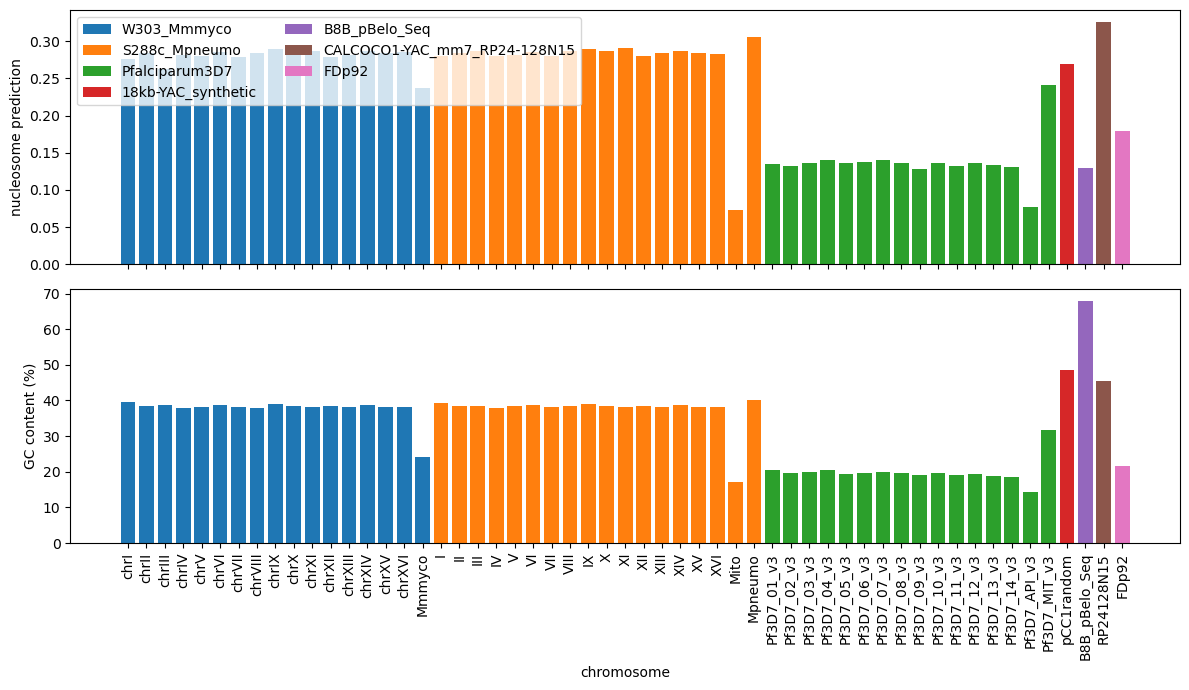

In [4]:
model_name = model_nuc_name
label = "nucleosome"  # polII  # cohesin

fig, axes = plt.subplots(
    2, 1, figsize=(12, 7), facecolor="w", layout="tight", sharex=True
)
for genome_name in [
    "W303_Mmmyco",
    "S288c_Mpneumo",
    "Pfalciparum3D7",
    "18kb-YAC_synthetic",
    "B8B_pBelo_Seq",
    "CALCOCO1-YAC_mm7_RP24-128N15",
    "FDp92",
]:
    file = Path(
        resdir, model_name, f"preds_{model_name}_on_{genome_name}_mid_track0.bw"
    )
    file_annot = get_avg_annot_bychr(file)
    axes[0].bar(
        list(file_annot.keys()),
        list(file_annot.values()),
        label=genome_name,
    )
    fastafile = genome_name_to_fasta(genome_name)
    file_gc = get_gc_bychr(fastafile)
    axes[1].bar(
        list(file_gc.keys()),
        list(file_gc.values()),
        label=genome_name,
    )
axes[0].set_ylabel(f"{label} prediction")
axes[1].set_ylabel("GC content (%)")
axes[1].set_xlabel("chromosome")
plt.xticks(rotation=90)
axes[0].legend(loc="upper left", ncol=2)
plt.show()

In [5]:
all_annot_gc = {}
for genome_name in [
    "W303_Mmmyco",
    "S288c_Mpneumo",
    "Pfalciparum3D7",
    "18kb-YAC_synthetic",
    "B8B_pBelo_Seq",
    "CALCOCO1-YAC_mm7_RP24-128N15",
    "FDp92",
]:
    nucfilename = Path(
        resdir, model_nuc_name, f"preds_{model_nuc_name}_on_{genome_name}_mid_track0.bw"
    )
    file_nuc = get_avg_annot_bychr(nucfilename)
    polfilename = Path(
        resdir, model_pol_name, f"preds_{model_pol_name}_on_{genome_name}_mid_track0.bw"
    )
    file_pol = get_avg_annot_bychr(polfilename)
    # if genome_name == "18kb-YAC_synthetic":
    #     file_coh = {"pCC1random": np.nan}
    # else:
    #     cohfilename = Path(
    #         resdir, model_coh_name, f"preds_{model_coh_name}_on_{genome_name}.bw"
    #     )
    #     file_coh = get_avg_annot_bychr(cohfilename)
    fastafilename = genome_name_to_fasta(genome_name)
    file_gc = get_gc_bychr(fastafilename)
    for k in file_nuc.keys():
        all_annot_gc[k] = (
            genome_name,
            file_gc[k],
            file_nuc[k],
            file_pol[k],
            # file_coh[k] if k in file_coh.keys() else np.nan,
        )
all_annot_gc = pd.DataFrame(
    all_annot_gc,
    index=["genome", "gc", "nucleosome", "polII"],  # , "cohesin"]
).T

In [39]:
# all_annot_gc.to_csv("/home/alex/shared_folder/SCerevisiae/results/model_myco_nuc_2/table_average_pred_by_chr.csv")

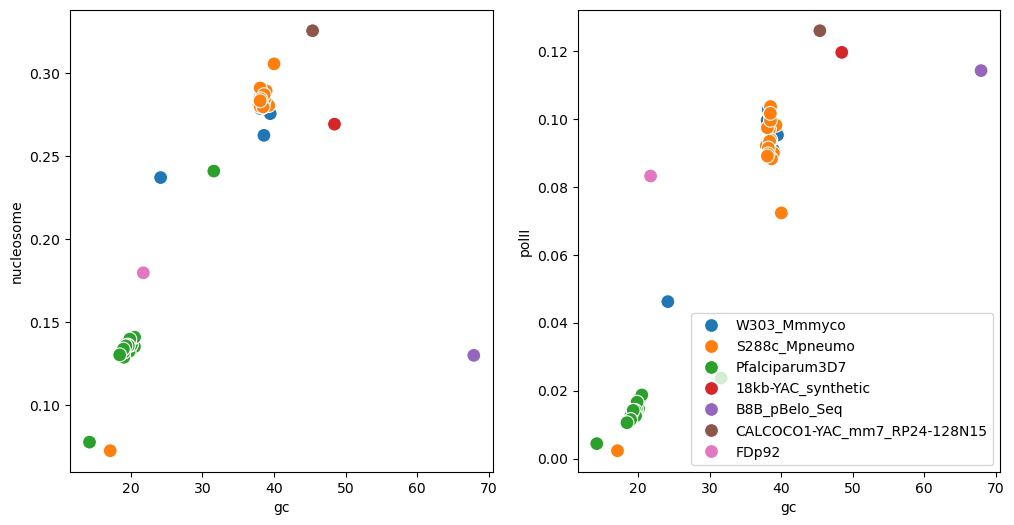

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), facecolor="w")
for ax, col in zip(axes, ["nucleosome", "polII"]):
    sns.scatterplot(
        data=all_annot_gc,
        x="gc",
        y=col,
        hue="genome",
        ax=ax,
        legend=col == "polII",
        s=100,
    )
axes[1].legend()

In [64]:
files = {
    "model_myco_nuc_pt8": "preds_model_myco_nuc_pt8_random_strictGCrange_indep_100.npy",
    "model_myco_nuc_pt17": "preds_model_myco_nuc_pt17_random_strictGCrange_indep_100.npy",
    "model_myco_pol_pt8": "preds_model_myco_pol_pt8_random_strictGCrange_indep_100.npy",
    "model_myco_nucpol_pt8": "preds_model_myco_nucpol_pt8_random_strictGCrange_indep_100.npy",
}
preds_rand = {
    model_name: np.load(Path(resdir, model_name, filename))
    for model_name, filename in files.items()
}
n_gcs = len(preds_rand["model_myco_nuc_pt8"])
gcs = np.linspace(0, 1, n_gcs)

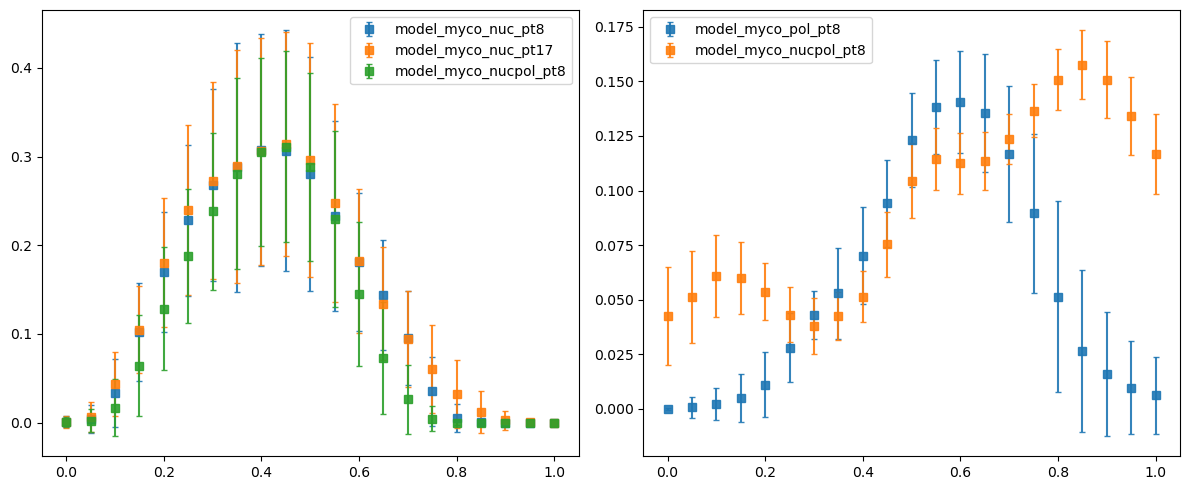

In [69]:
fig, axes = plt.subplots(
    1, 2, figsize=(12, 5), facecolor="w", layout="tight", sharex=True
)
for model_name, preds in preds_rand.items():
    if preds.shape[-1] == 2:
        axes[0].errorbar(
            gcs,
            y=preds[..., 0].reshape(n_gcs, -1).mean(axis=-1),
            yerr=preds[..., 0].reshape(n_gcs, -1).std(axis=-1),
            fmt="s",
            alpha=0.9,
            label=model_name,
            capsize=2,
        )
        axes[1].errorbar(
            gcs,
            y=preds[..., 1].reshape(n_gcs, -1).mean(axis=-1),
            yerr=preds[..., 1].reshape(n_gcs, -1).std(axis=-1),
            fmt="s",
            alpha=0.9,
            label=model_name,
            capsize=2,
        )
    else:
        if "nuc" in model_name:
            ax_idx = 0
        elif "pol" in model_name:
            ax_idx = 1
        axes[ax_idx].errorbar(
            gcs,
            y=preds.reshape(n_gcs, -1).mean(axis=-1),
            yerr=preds.reshape(n_gcs, -1).std(axis=-1),
            fmt="s",
            alpha=0.9,
            label=model_name,
            capsize=2,
        )
for ax in axes:
    ax.legend()

In [29]:
files = {
    "randnuc1": "preds_myco_pneu_v1_nucleosome_random_strictGCrange_indep_10000.npy",
    "randnuc2": "preds_myco_pneu_2_rep2_nucleosome_random_strictGCrange_indep_10000.npy",
    "randnuc3": "preds_myco_pneu_2_rep3_nucleosome_random_strictGCrange_indep_10000.npy",
    "randpol1": "preds_myco_pneu_17_pol_random_strictGCrange_indep_32.npy",
    "randpol2": "preds_myco_pneu_17_rep2_pol_random_strictGCrange_indep_32.npy",
    "randpol3": "preds_myco_pneu_17_rep3_pol_random_strictGCrange_indep_32.npy",
    "randcoh1": "preds_myco_pneu_14_cohesine_random_strictGCrange_indep_32.npy",
    "randcoh2": "preds_myco_pneu_14_rep2_cohesine_random_strictGCrange_indep_32.npy",
    "randcoh3": "preds_myco_pneu_14_rep3_cohesine_random_strictGCrange_indep_32.npy",
}
preds_rand = {
    k: np.load(
        Path(
            yeastdir,
            "results",
            "random_seqs",
            filename,
        )
    ).reshape(21, 2, -1)
    for k, filename in files.items()
}
n_gcs = len(preds_rand["randnuc1"])
gcs = np.linspace(0, 1, n_gcs)
preds_nuc_rand_reps = np.stack([v for k, v in preds_rand.items() if "nuc" in k], axis=2)
preds_pol_rand_reps = np.stack([v for k, v in preds_rand.items() if "pol" in k], axis=2)
preds_coh_rand_reps = np.stack([v for k, v in preds_rand.items() if "coh" in k], axis=2)

In [36]:
rand_summary = {}
rand_summary["gc"] = np.arange(0, 101, 5)
rand_summary["rand_nuc_mean"] = preds_nuc_rand_reps[:, 0, 0].mean(axis=-1)
rand_summary["rand_nuc_std"] = preds_nuc_rand_reps[:, 0, 0].std(axis=-1)
rand_summary["rand_pol_mean"] = preds_pol_rand_reps[:, 0, 0].mean(axis=-1)
rand_summary["rand_pol_std"] = preds_pol_rand_reps[:, 0, 0].std(axis=-1)
rand_summary["rand_coh_mean"] = preds_coh_rand_reps[:, 0, 0].mean(axis=-1)
rand_summary["rand_coh_std"] = preds_coh_rand_reps[:, 0, 0].std(axis=-1)
df_rand = pd.DataFrame(rand_summary)
# df_rand.to_csv(
#     "/home/alex/shared_folder/SCerevisiae/results/random_seqs/table_preds_myco_rep1_on_random.csv",
#     index=False,
# )

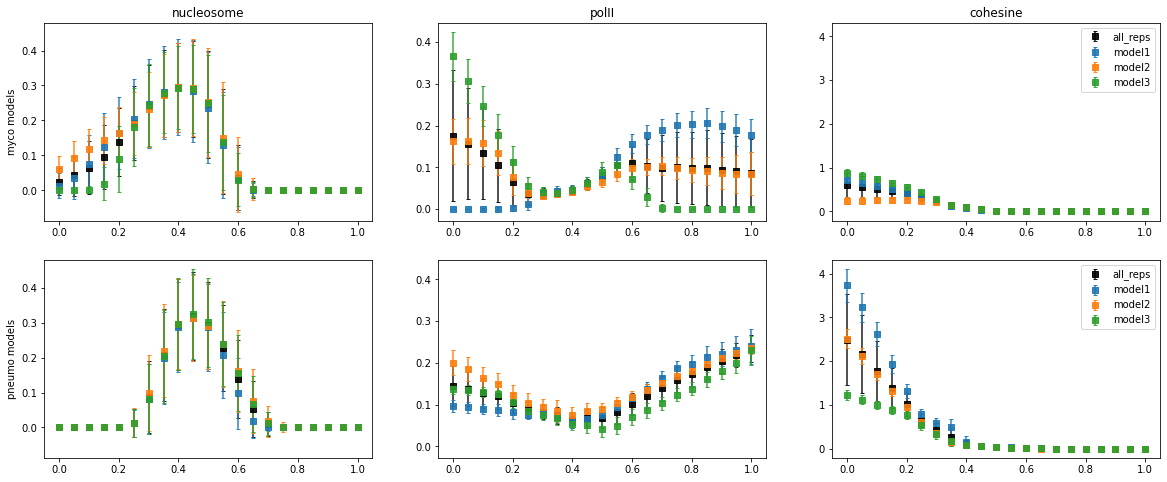

In [276]:
nrow = 2
ncol = 3
fmts = ["bs", "rs", "gs"]
annots = ["nucleosome", "polII", "cohesine"]
ylabels = ["myco models", "pneumo models"]
fig, axes = plt.subplots(nrow, ncol, sharey="col", figsize=(20, 8), facecolor="w")
for col in range(ncol):
    axes[0, col].set_title(annots[col])
for row in range(nrow):
    for col, preds in enumerate(
        [preds_nuc_rand_reps, preds_pol_rand_reps, preds_coh_rand_reps]
    ):
        n_rep = preds.shape[2]
        if row == 0:
            preds = preds[:, 0]
        elif row == 1:
            preds = preds[:, 1]
        # Global average plot
        axes[row, col].errorbar(
            gcs,
            y=preds.reshape(n_gcs, -1).mean(axis=-1),
            yerr=preds.reshape(n_gcs, -1).std(axis=-1),
            fmt="ks",
            alpha=0.9,
            label="all_reps",
            capsize=2,
        )
        # Average plot by model replicate
        means = preds.reshape(n_gcs, n_rep, -1).mean(axis=2)
        stds = preds.reshape(n_gcs, n_rep, -1).std(axis=2)
        for i in range(n_rep):
            axes[row, col].errorbar(
                gcs,
                y=means[:, i],
                yerr=stds[:, i],
                fmt="s",
                alpha=0.9,
                label=f"model{i+1}",
                capsize=2,
            )
    axes[row, 0].set_ylabel(ylabels[row])
    axes[row, col].legend()
# axes[0, 1].set_ylim((-0.05, 1))

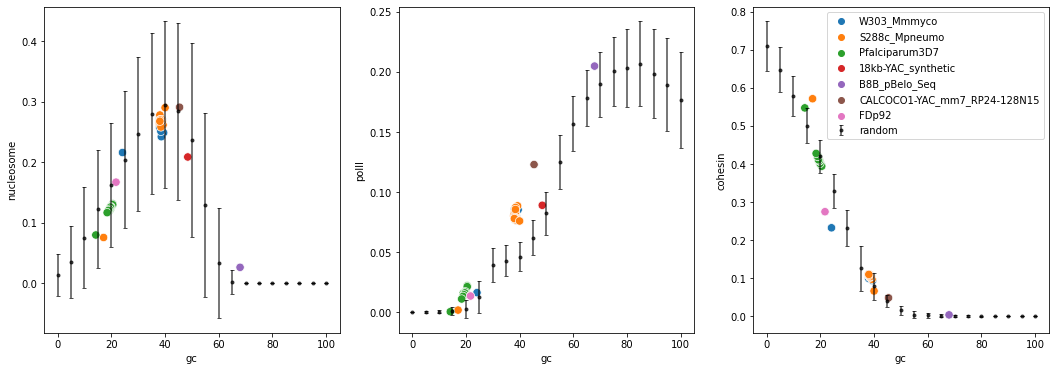

In [213]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), facecolor="w")
for ax, col, preds_rand in zip(
    axes,
    ["nucleosome", "polII", "cohesin"],
    [preds_nuc_rand_reps, preds_pol_rand_reps, preds_coh_rand_reps],
):
    ax.errorbar(
        gcs * 100,
        y=preds_rand[:, 0, 0].mean(axis=-1),
        yerr=preds_rand[:, 0, 0].std(axis=-1),
        fmt="k.",
        alpha=0.7,
        label="random",
        capsize=2,
    )
    sns.scatterplot(
        data=all_annot_gc,
        x="gc",
        y=col,
        hue="genome",
        ax=ax,
        legend=(col == "cohesin"),
        s=70,
    )
axes[2].legend()

In [5]:
genome_names

['W303_Mmmyco',
 'S288c_Mpneumo',
 'Pfalciparum3D7',
 '18kb-YAC_synthetic',
 'B8B_pBelo_Seq',
 'CALCOCO1-YAC_mm7_RP24-128N15',
 'FDp92']

In [6]:
from scipy.fft import fft, fftfreq


def merge_preds(file):
    merge = {}
    with pyBigWig.open(str(file)) as bw:
        for chr_id, length in bw.chroms().items():
            values = bw.values(chr_id, 0, -1, numpy=True)
            indices = np.isfinite(values).nonzero()[0]
            values = values[indices]
            if chr_id[:-4] in merge:
                merge[chr_id[:-4]] = utils.mean_on_index(
                    merge[chr_id[:-4]], (indices, values), length=length
                )
            else:
                merge[chr_id[:-4]] = (indices, values)
    return merge


def fast_autocorr(y):
    centered_signal = y - np.mean(y)
    corrs = scipy.signal.correlate(centered_signal, centered_signal, mode="full")
    lags = scipy.signal.correlation_lags(y.size, y.size, mode="full")
    corrs /= corrs[lags == 0]
    return lags, corrs

In [7]:
nrl_min, nrl_max = 140, 220
binsize = 2000
nrl_distrib = {}
rng = np.random.default_rng()
for genome_name in genome_names:
    merge = merge_preds(
        Path(
            resdir,
            model_nuc_name,
            f"preds_{model_nuc_name}_on_{genome_name}_mid_track0.bw",
        )
    )
    for k, y in merge.items():
        y = utils.nan_smooth(y, 8, pad_masked=True)
        y[np.isnan(y)] = 0
        best_autocorr_list = []
        for y_bin in np.split(y, np.arange(binsize, len(y), binsize)):
            if len(y_bin) < binsize // 2:
                continue
            lags, corrs = fast_autocorr(y_bin)
            best_autocorr = nrl_min + np.argmax(
                corrs[(lags >= nrl_min) & (lags < nrl_max)]
            )
            if best_autocorr in [nrl_min, nrl_max - 1]:
                best_autocorr = np.nan
            best_autocorr_list.append(best_autocorr)
        nrl_distrib[k.split()[0]] = (genome_name, best_autocorr_list)
df_nrl = pd.DataFrame(nrl_distrib, index=["genome", "nrl distrib"]).T

/tmp/ipykernel_1239683/315135438.py:24: RuntimeWarning: invalid value encountered in divide
  corrs /= corrs[lags == 0]


In [8]:
df_nrl_group = df_nrl.copy()
df_nrl_group.loc["Mmmyco", "genome"] = "Mmmyco"
df_nrl_group.loc["Mpneumo", "genome"] = "Mpneumo"
df_nrl_group.loc["Mito", "genome"] = "Mito"
df_nrl_group.loc["Pf3D7_API_v3", "genome"] = "Pf3D7_API_v3"
df_nrl_group.loc["Pf3D7_MIT_v3", "genome"] = "Pf3D7_MIT_v3"
df_nrl_group = df_nrl_group.groupby("genome").sum()

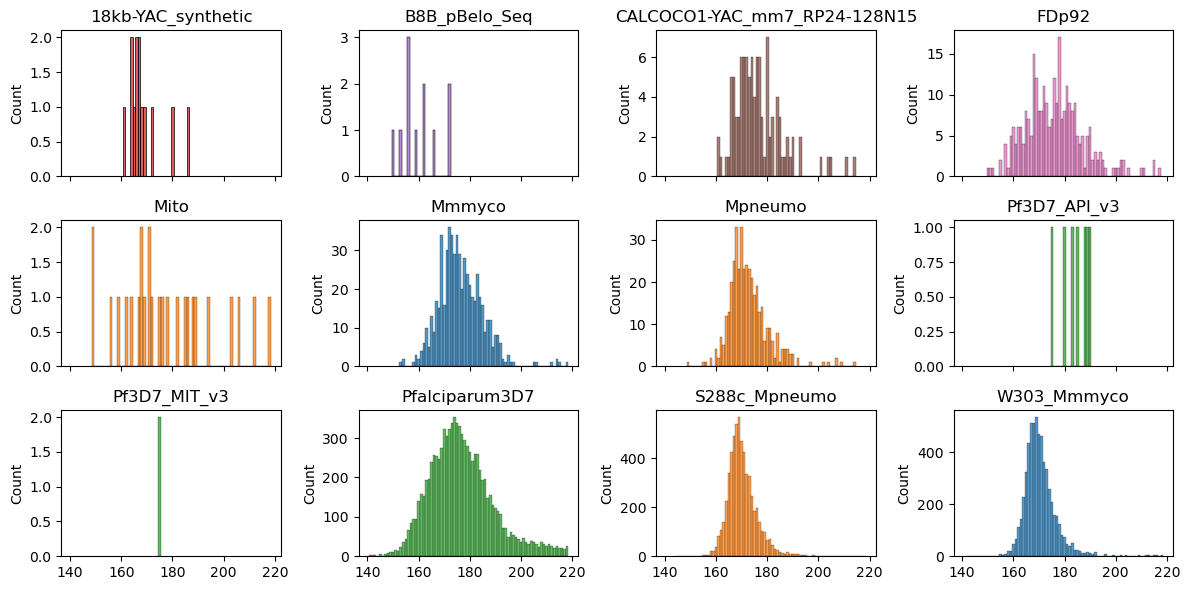

In [9]:
fig, axes = plt.subplots(
    3, 4, figsize=(12, 6), facecolor="w", layout="tight", sharex=True
)
genome_to_idx = {name: i for i, name in enumerate(genome_names)}
for ax, group in zip(axes.flatten(), df_nrl_group.index):
    if group in genome_names:
        genome_name = group
    else:
        genome_name = df_nrl.loc[group, "genome"]
    i = genome_to_idx[genome_name]
    sns.histplot(
        df_nrl_group.loc[group, "nrl distrib"],
        discrete=True,
        ax=ax,
        color=colors[i % len(colors)],
    )
    ax.set_title(group)

Text(0.5, 0, 'nrl')

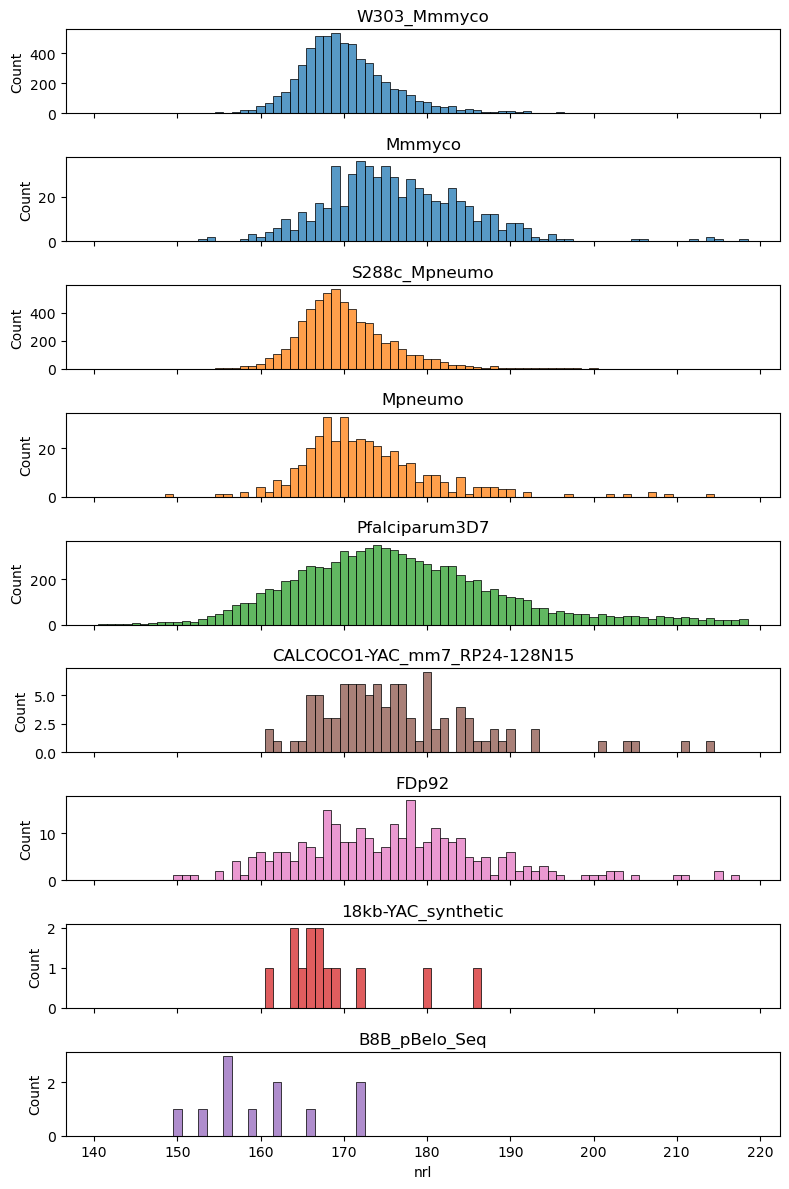

In [10]:
fig, axes = plt.subplots(
    9, 1, figsize=(8, 12), facecolor="w", layout="tight", sharex=True
)
for ax, group in zip(
    axes.flatten(),
    [
        "W303_Mmmyco",
        "Mmmyco",
        "S288c_Mpneumo",
        "Mpneumo",
        "Pfalciparum3D7",
        "CALCOCO1-YAC_mm7_RP24-128N15",
        "FDp92",
        "18kb-YAC_synthetic",
        "B8B_pBelo_Seq",
    ],
):
    if group in genome_names:
        genome_name = group
    else:
        genome_name = df_nrl.loc[group, "genome"]
    i = genome_to_idx[genome_name]
    sns.histplot(
        df_nrl_group.loc[group, "nrl distrib"],
        discrete=True,
        ax=ax,
        color=colors[i % len(colors)],
        binrange=(nrl_min + 1, nrl_max - 2),
    )
    ax.set_title(group)
ax.set_xlabel("nrl")

In [11]:
datafiles = {
    "labels_myco": "labels_myco_nuc.bw",
    "labels_pneu": "labels_pneu_nuc.bw",
    "mnase_myco": "mnase_myco.bw",
    "mnase_pneu": "mnase_pneumo.bw",
    "mnase_Struhl": "JSerizay_2024_04_12/SRR22031263_mnase-cov.bw",
}

In [12]:
nrl_min, nrl_max = 140, 220
binsize = 2000
nrl_data_distrib = {}
for dataid, datafile in datafiles.items():
    suff = ""
    if "labels" in dataid:
        suff = "_lab"
    if "Struhl" in dataid:
        suff = "_Struhl"
    merge = {}
    with pyBigWig.open(str(Path(yeastdir, "data", datafile))) as bw:
        for chrom in bw.chroms():
            merge[chrom] = bw.values(chrom, 0, -1, numpy=True)
    for k, y in merge.items():
        y[np.isnan(y)] = 0
        best_autocorr_list = []
        for y_bin in np.split(y, np.arange(binsize, len(y), binsize)):
            if len(y_bin) < binsize // 2:
                continue
            lags, corrs = fast_autocorr(y_bin)
            best_autocorr = nrl_min + np.argmax(
                corrs[(lags >= nrl_min) & (lags < nrl_max)]
            )
            if best_autocorr in [nrl_min, nrl_max - 1]:
                best_autocorr = np.nan
            best_autocorr_list.append(best_autocorr)
        nrl_data_distrib[k.split()[0] + suff] = (dataid, best_autocorr_list)
df_data_nrl = pd.DataFrame(nrl_data_distrib, index=["dataid", "nrl distrib"]).T

/tmp/ipykernel_1239683/315135438.py:24: RuntimeWarning: invalid value encountered in divide
  corrs /= corrs[lags == 0]


In [13]:
df_data_nrl_group = df_data_nrl.copy()
df_data_nrl_group.loc["Mmmyco_lab", "dataid"] = "Mmmyco_lab"
df_data_nrl_group.loc["Mpneumo_lab", "dataid"] = "Mpneumo_lab"
df_data_nrl_group.loc["Mmmyco", "dataid"] = "Mmmyco"
df_data_nrl_group.loc["Mpneumo", "dataid"] = "Mpneumo"
df_data_nrl_group.loc["chrXVII_Struhl", "dataid"] = "chrXVII_Struhl"
df_data_nrl_group = df_data_nrl_group.groupby("dataid").sum()

Text(0.5, 0, 'nrl')

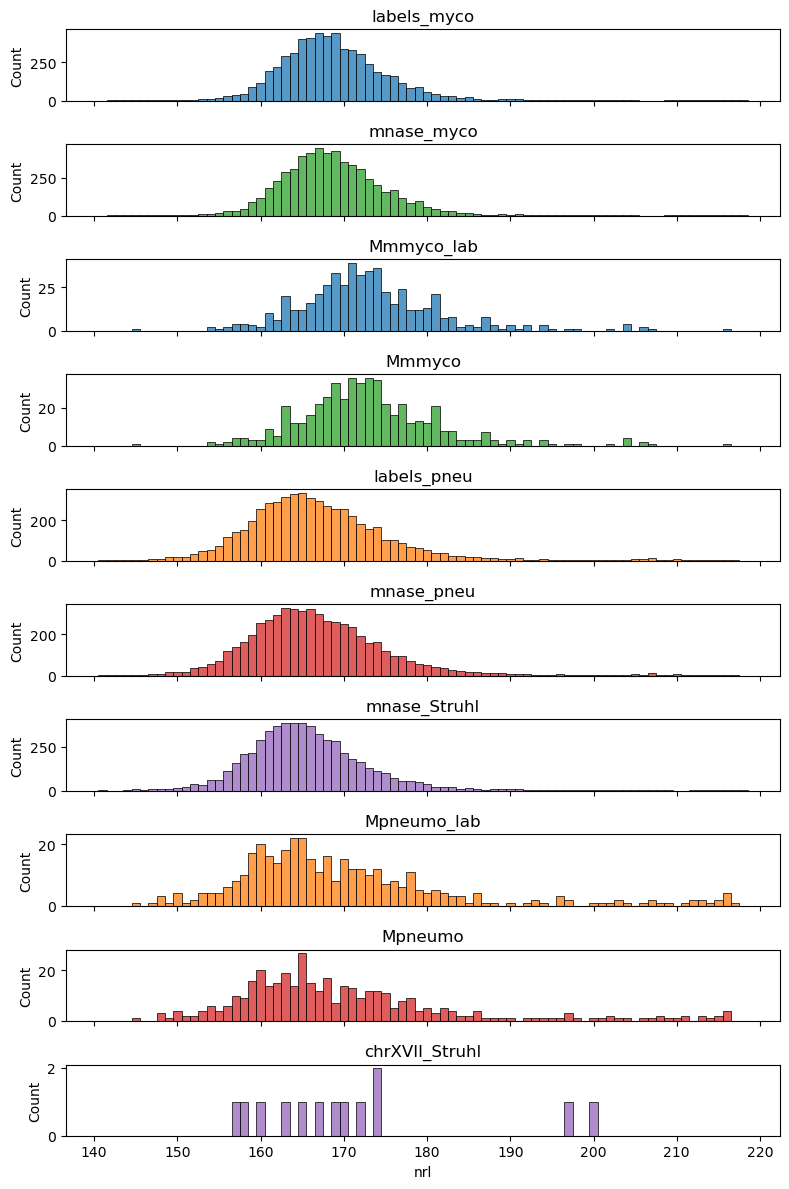

In [14]:
fig, axes = plt.subplots(
    10, 1, figsize=(8, 12), facecolor="w", layout="tight", sharex=True
)
dataid_to_idx = {name: i for i, name in enumerate(datafiles.keys())}
for ax, group in zip(
    axes.flatten(),
    [
        "labels_myco",
        "mnase_myco",
        "Mmmyco_lab",
        "Mmmyco",
        "labels_pneu",
        "mnase_pneu",
        "mnase_Struhl",
        "Mpneumo_lab",
        "Mpneumo",
        "chrXVII_Struhl",
    ],
):
    if group in datafiles.keys():
        dataid = group
    else:
        dataid = df_data_nrl.loc[group, "dataid"]
    i = dataid_to_idx[dataid]
    sns.histplot(
        df_data_nrl_group.loc[group, "nrl distrib"],
        discrete=True,
        ax=ax,
        color=colors[i % len(colors)],
        binrange=(nrl_min + 1, nrl_max - 2),
    )
    ax.set_title(group)
ax.set_xlabel("nrl")

In [15]:
df_nrl_group.index, df_data_nrl_group.index

(Index(['18kb-YAC_synthetic', 'B8B_pBelo_Seq', 'CALCOCO1-YAC_mm7_RP24-128N15',
        'FDp92', 'Mito', 'Mmmyco', 'Mpneumo', 'Pf3D7_API_v3', 'Pf3D7_MIT_v3',
        'Pfalciparum3D7', 'S288c_Mpneumo', 'W303_Mmmyco'],
       dtype='object', name='genome'),
 Index(['Mmmyco', 'Mmmyco_lab', 'Mpneumo', 'Mpneumo_lab', 'chrXVII_Struhl',
        'labels_myco', 'labels_pneu', 'mnase_Struhl', 'mnase_myco',
        'mnase_pneu'],
       dtype='object', name='dataid'))

mnase_myco 6095 5748
mnase_pneu 6034 5643
mnase_Struhl 6034 5676
Mmmyco 611 500
Mpneumo 409 381
chrXVII_Struhl 14 13


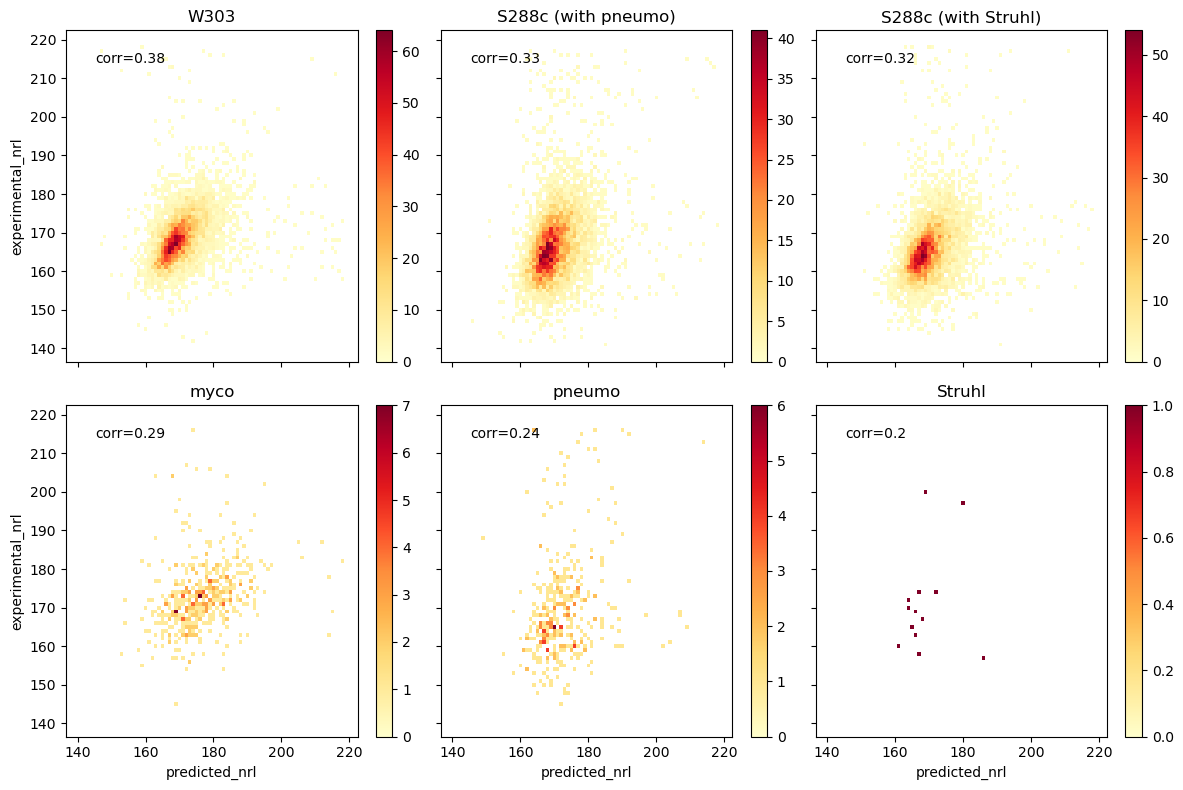

In [18]:
fig, axes = plt.subplots(
    2, 3, figsize=(12, 8), facecolor="w", layout="tight", sharex=True, sharey=True
)
for ax, (exp_name, pred_name, title) in zip(
    axes.flatten(),  # [[0, 1, 3, 4, 5]],
    [
        ("mnase_myco", "W303_Mmmyco", "W303"),
        ("mnase_pneu", "S288c_Mpneumo", "S288c (with pneumo)"),
        ("mnase_Struhl", "S288c_Mpneumo", "S288c (with Struhl)"),
        ("Mmmyco", "Mmmyco", "myco"),
        ("Mpneumo", "Mpneumo", "pneumo"),
        ("chrXVII_Struhl", "18kb-YAC_synthetic", "Struhl"),
    ],
):
    df = pd.DataFrame(
        {
            "predicted_nrl": df_nrl_group.loc[pred_name, "nrl distrib"],
            "experimental_nrl": df_data_nrl_group.loc[exp_name, "nrl distrib"],
            # "labels_nrl": df_data_nrl_group.loc["labels_pneu", "nrl distrib"]
        }
    )
    print(exp_name, len(df), end=" ")
    df[(df == nrl_min) | (df == nrl_max - 1)] = np.nan
    df.dropna(inplace=True)
    print(len(df))
    sns.histplot(
        df,
        x="predicted_nrl",
        y="experimental_nrl",
        discrete=True,
        cmap="YlOrRd",
        cbar=True,
        ax=ax,
        binrange=(nrl_min + 1, nrl_max - 2),
    )
    ax.annotate(
        f'corr={df.corr().loc["predicted_nrl", "experimental_nrl"].round(2)}',
        (0.1, 0.9),
        xycoords="axes fraction",
    )
    ax.set_title(title)

In [31]:
with pyBigWig.open(str(Path(yeastdir, "data", "W303_Mmmyco_vs-gDNA.bw"))) as bw:
    atac = {k: bw.values(k, 0, -1, numpy=True) for k in bw.chroms()}
df_summary = {}
q_list = [0.5, 0.9, 0.99, 0.999]
for k, v in atac.items():
    df_summary[k] = [
        np.isnan(v).sum(),
        len(v),
        np.isnan(v).sum() / len(v),
        np.nanmin(v),
        np.nanmax(v),
        np.nanmean(v),
    ] + list(np.nanquantile(v, q_list))
df_summary = pd.DataFrame(
    df_summary,
    index=["nan_count", "length", "nan_prop", "min", "max", "mean"]
    + [f"q{q}" for q in q_list],
).T
df_summary

,nan_count,length,nan_prop,min,max,mean,q0.5,q0.9,q0.99,q0.999
chrI,10880.0,245675.0,0.044286,0.092296,19.017900,0.860716,0.508624,1.780562,5.079150,9.913804
chrII,13228.0,818518.0,0.016161,0.071687,10.495900,0.880993,0.551585,1.867740,5.021970,6.749870
chrIII,26915.0,347597.0,0.077432,0.083505,11.460000,0.882537,0.560363,1.812140,5.195740,7.367080
chrIV,78414.0,1548464.0,0.050640,0.056056,56.854500,0.933543,0.561211,1.969894,5.601520,9.200090
chrV,24710.0,590080.0,0.041876,0.086877,118.744003,1.025880,0.598693,2.339130,5.745200,9.090590
chrVI,9293.0,271173.0,0.034270,0.070145,8.203170,0.897384,0.566681,1.897270,4.991520,6.929460
chrVII,29638.0,1090383.0,0.027181,0.096553,22.354900,1.006569,0.584944,2.256348,5.927140,8.293130
chrVIII,35240.0,580970.0,0.060657,0.055716,186.117004,0.877047,0.538813,1.800930,4.742640,7.819680
chrIX,16016.0,429631.0,0.037279,0.098220,22.570000,0.873340,0.551563,1.743730,5.142090,10.675300
chrX,25085.0,751537.0,0.033378,0.045290,180.699005,0.871585,0.544437,1.886600,4.764023,6.835440


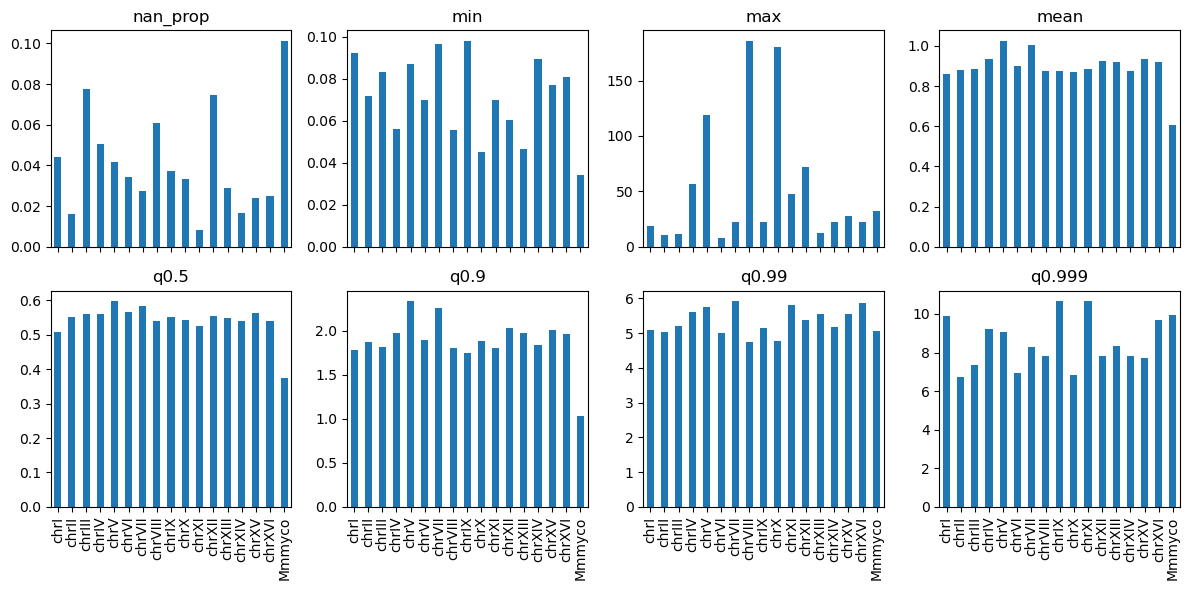

In [43]:
fig, axes = plt.subplots(
    2, 4, figsize=(12, 6), facecolor="w", layout="tight", sharex=True
)
for col, ax in zip(df_summary.loc[:, "nan_prop":].columns, axes.flatten()):
    df_summary[col].plot(kind="bar", ax=ax)
    ax.set_title(col)

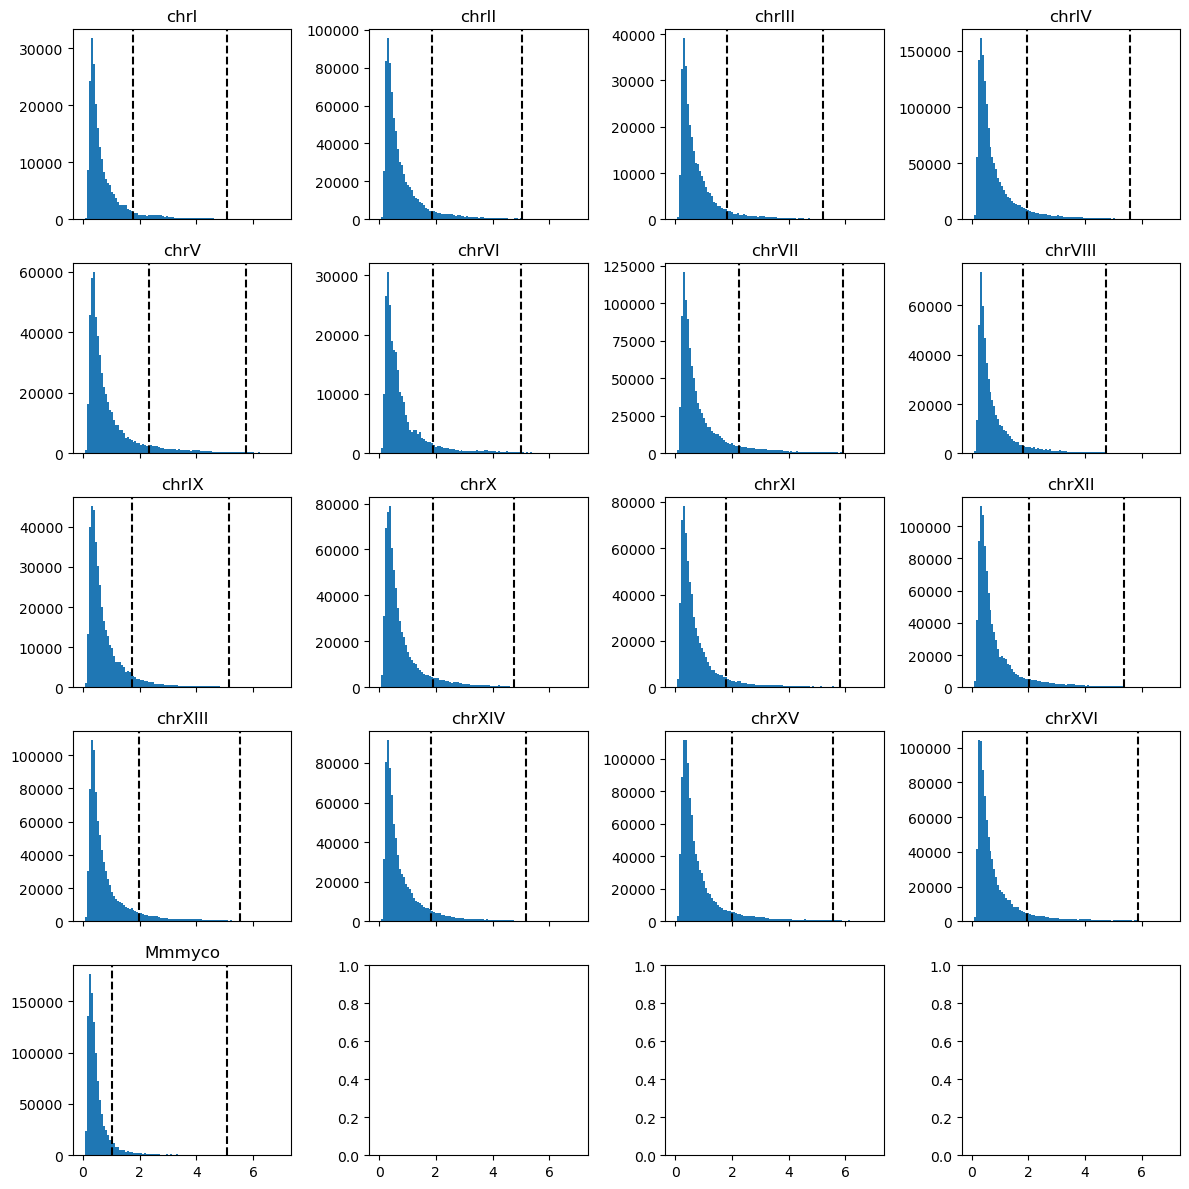

In [49]:
fig, axes = plt.subplots(
    5, 4, figsize=(12, 12), facecolor="w", layout="tight", sharex=True
)
for (k, v), ax in zip(atac.items(), axes.flatten()):
    v = v[np.isfinite(v)]
    ax.hist(v, bins=100, range=(0, 7))
    for q in np.quantile(v, [0.9, 0.99]):
        ax.axvline(x=q, color="k", linestyle="--")
    ax.set_title(k)

In [55]:
with pyBigWig.open(str(Path(yeastdir, "data", "mnase_myco.bw"))) as bw:
    mnase = {k: bw.values(k, 0, -1, numpy=True) for k in bw.chroms()}

In [218]:
for k, v in atac.items():
    if np.nanmax(v) > 50:
        print(k, (v > 50).nonzero())

chrIV (array([1527730, 1527731, 1527732, 1527733, 1527734, 1527735, 1527736,
       1527737, 1527738, 1527739, 1527740, 1527741, 1527742, 1527743,
       1527744, 1527745, 1527746, 1527747, 1527748, 1527749]),)
chrV (array([558070, 558071, 558072, 558073, 558074, 558075, 558076, 558077,
       558078, 558079, 558080, 558081, 558082, 558083, 558084, 558085,
       558086, 558087, 558088, 558089, 558090, 558091, 558092, 558093,
       558094]),)
chrVIII (array([307640, 307641, 307642, 307643, 307644, 307645, 307646, 307647,
       307648, 307649, 307650, 307651, 307652, 307653, 307654, 307655,
       307656, 307657, 307658, 307659, 307660, 307661, 307662, 307663,
       307664, 307665, 307666, 307667, 307668, 307669, 307670, 307671,
       307672, 307673, 307674, 307675, 307676, 307677, 307678, 307679,
       307680, 307681, 307682, 307683, 307684, 307685, 307686, 307687,
       307688, 307689, 307690, 307691, 307692, 307693, 307694, 307695,
       307696, 307697, 307698, 307699]),)
chrX

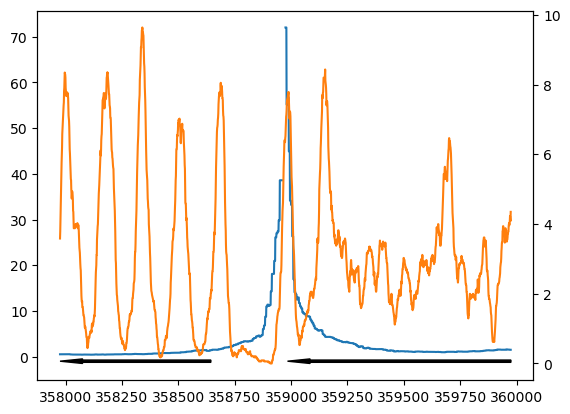

In [225]:
chr_id = "chrXII"
start = 358975 - 1000
stop = start + 2000
fig, ax = plt.subplots(1, 1)
ax.plot(
    np.arange(start, stop),
    atac[chr_id][start:stop],
)
ax2 = ax.twinx()
ax2.plot(np.arange(start, stop), mnase[chr_id][start:stop], color=colors[1])
for idx in genes[
    (genes.seqid == chr_id) & (genes.start < stop) & (genes.stop > start)
].index:
    gene_start, gene_stop, strand = genes.loc[idx, "start":]
    gene_start = max(start, gene_start)
    gene_stop = min(stop, gene_stop)
    if strand == "-":
        gene_start, gene_stop = gene_stop, gene_start
    # print(gene_start, gene_stop, forward)
    ax.arrow(
        gene_start,
        -1,
        gene_stop - gene_start,
        0,
        color="k",
        width=0.5,
        head_width=1,
        head_length=100,
        length_includes_head=True,
        # label=arrow_label,
    )

In [164]:
gff3 = pd.read_csv(
    Path(yeastdir, "genome", "W303_Mmmyco.gff3"), sep="\t", header=None, skiprows=1
)
gff3.columns = [
    "seqid",
    "source",
    "type",
    "start",
    "stop",
    "score",
    "strand",
    "phase",
    "attributes",
]
# gff3["attributes"].apply(lambda x: dict([e.split("=", maxsplit=1) for e in x.split(";") if "=" in e]))
gff3

,seqid,source,type,start,stop,score,strand,phase,attributes
0,chrI,W303,X_element,469,933,.,-,.,ID=X_element:chrI:469-933:-;Name=X_element:chr...
1,chrI,W303,gene,670,924,.,+,.,ID=W303_G0000010;Name=W303_G0000010
2,chrI,W303,mRNA,670,924,.,+,.,ID=W303_G0000010.mRNA.1;Name=W303_G0000010.mRN...
3,chrI,W303,exon,670,924,.,+,.,ID=W303_G0000010.mRNA.1.exon.1;Name=W303_G0000...
4,chrI,W303,CDS,670,924,.,+,0,ID=W303_G0000010.mRNA.1.CDS.1;Name=W303_G00000...
...,...,...,...,...,...,...,...,...,...
28621,Mmmyco,Liftoff,CDS,1206674,1207117,.,-,.,ID=CDS:CAE77254;Parent=transcript:CAE77254;pro...
28622,Mmmyco,Liftoff,gene,1207132,1209384,.,-,.,ID=gene:MSC_0633;biotype=protein_coding;descri...
28623,Mmmyco,Liftoff,mRNA,1207132,1209384,.,-,.,ID=transcript:CAE77255;Parent=gene:MSC_0633;bi...
28624,Mmmyco,Liftoff,exon,1207132,1209384,.,-,.,ID=exon_620;Parent=transcript:CAE77255;Name=CA...


In [197]:
genes = gff3.loc[gff3.type == "gene", ["seqid", "start", "stop", "strand"]]
genes

,seqid,start,stop,strand
1,chrI,670,924,+
5,chrI,1939,2301,-
9,chrI,2612,2839,+
13,chrI,7369,9150,-
17,chrI,11699,12085,-
...,...,...,...,...
28606,Mmmyco,1203049,1203924,-
28610,Mmmyco,1203933,1204475,-
28614,Mmmyco,1204719,1206155,-
28618,Mmmyco,1206674,1207117,-


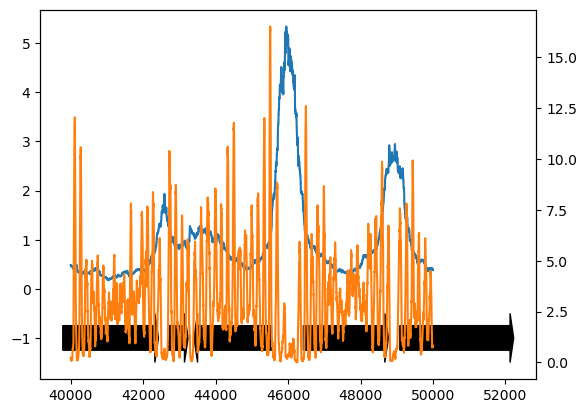

In [207]:
fig, ax = plt.subplots(1, 1)
start = 40000
stop = start + 10000
ax.plot(np.arange(start, stop), atac["chrI"][start:stop])
ax2 = ax.twinx()
ax2.plot(np.arange(start, stop), mnase["chrI"][start:stop], color=colors[1])
for idx in genes[
    (genes.seqid == "chrI") & (genes.start < stop) & (genes.stop > start)
].index:
    gene_start, gene_stop, strand = genes.loc[idx, "start":]
    if strand == "-":
        gene_start, gene_stop = gene_stop, gene_start
    # print(gene_start, gene_stop, forward)
    ax.arrow(
        gene_start,
        -1,
        gene_stop - gene_start,
        0,
        color="k",
        width=0.5,
        head_width=1,
        head_length=100,
        length_includes_head=True,
        # label=arrow_label,
    )